<h6 style= 'color: blue'>  Часть третья </h6> 
  

In [1]:
# Импортируем библиотеку numpy для работы с линейной алгеброй
import numpy as np
# Импортируем библиотеку pandas для работы с данными, чтения и записи файлов в формате CSV
import pandas as pd
# Импортируем модуль warnings для управления предупреждениями, которые могут возникать при выполнении кода
import warnings
# Используем метод filterwarnings для игнорирования всех предупреждений
warnings.filterwarnings("ignore")
# Импортируем модуль sklearn.model_selection для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Импортируем функции для оценки качества классификации
# Функция classification_report строит текстовый отчет, показывающий основные метрики классификации, такие как точность, 
# полнота и F1-мера для каждого класса 
# Функция confusion_matrix вычисляет матрицу ошибок, чтобы оценить точность классификации 
# Класс ConfusionMatrixDisplay позволяет визуализировать матрицу ошибок с помощью matplotlib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Импортируем модуль sklearn.preprocessing для стандартизации данных
from sklearn.preprocessing import StandardScaler

In [3]:
# Устанавливаем библиотеку pyod - это инструмент для обнаружения выбросов в многомерных данных
# %pip install pyod

# Я пока закоментирую.

In [4]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [5]:
# Импортируем функцию evaluate_print из модуля pyod.utils.data
from pyod.utils.data import evaluate_print
# Функция evaluate_print принимает на вход истинные метки (y) и прогнозируемые оценки выбросов (scores) и 
# выводит метрики ROC-AUC и Precision
# ROC-AUC - это площадь под кривой ROC, которая показывает, насколько хорошо модель разделяет выбросы и нормальные объекты 
# Precision - это доля выбросов среди n объектов с самыми высокими оценками выбросов

Определяем функцию с метриками

In [6]:
# Определяем функцию, которая принимает на вход модель и истинные метки (y_train)
def metrics(model, y_train):
    # Получаем предсказанные метки (y_pred) из атрибута labels_ модели
    y_pred = model.labels_
    # Вызываем функцию evaluate_print из модуля pyod.utils.data, которая выводит метрики ROC-AUC и Precision
    evaluate_print(model.__class__, y_train, y_pred)
    # Вызываем функцию classification_report из модуля sklearn.metrics, которая строит текстовый отчет с основными
    # метриками классификации, такими как точность, полнота и F1-мера для каждого класса 
    print(classification_report(y_train, y_pred))
    # Вызываем функцию confusion_matrix из модуля sklearn.metrics, которая вычисляет матрицу ошибок, чтобы оценить
    # точность классификации 
    cm = confusion_matrix(y_train, y_pred)
    # Выводим матрицу ошибок
    print(cm)
    # Создаем объект класса ConfusionMatrixDisplay из модуля sklearn.metrics, передавая ему матрицу ошибок в
    # качестве аргумента 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Вызываем метод plot объекта disp, который визуализирует матрицу ошибок 
    disp.plot()


In [7]:
import numpy as np
# Устанавливаем случайное зерно для воспроизводимости результатов
np.random.seed(42)

Теоритическая справка
Seed - это значение, которое инициализирует генератор псевдослучайных чисел в Python. Это нужно для того, чтобы результаты генерации случайных чисел были воспроизводимыми. Если seed не задать, то каждый раз будут получаться разные случайные числа. np.random.seed(42) - это команда, которая устанавливает seed равным 42 для библиотеки numpy. Это число выбрано в качестве отсылки к книге “Автостопом по галактике”, где 42 - это ответ на главный вопрос жизни, вселенной.

## Загружаем данные для дальнейшего анализа

In [13]:
# Импортируем библиотеку pandas для работы с табличными данными
import pandas as pd

# Читаем файл creditcard.csv 
# Файл содержит информацию о транзакциях с кредитных карт, включая признаки и метку класса (0 - нормальная транзакция, 
# 1 - мошенническая транзакция) 
df = pd.read_csv('creditcard.csv')

# Удаляем столбцы Time и Class из датафрейма df с помощью метода drop и присваиваем результат переменной X
# Time - это время транзакции, которое не является полезным признаком для обнаружения мошенничества 
# Class - это целевая переменная, которую мы хотим предсказать, поэтому мы не включаем ее в признаки
X = df.drop(columns=['Time', 'Class'])

# Выбираем столбец Class из датафрейма df с помощью квадратных скобок и присваиваем результат переменной y
# Class - это целевая переменная, которая показывает, является ли транзакция мошеннической (1) или нормальной (0)
y = df.Class


Стандартизируем

In [14]:
# Пояснения Импортируем класс StandardScaler из модуля sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Создаем объект norm класса StandardScaler, который будет удалять среднее и масштабировать признаки к единичной дисперсии
norm = StandardScaler()

# Применяем метод fit_transform объекта norm к признакам X и преобразует их в стандартизованные значения 
# Результат преобразования - это двумерный массив numpy, который мы преобразуем в датафрейм pandas
# с помощью функции pd.DataFrame
X_norm = pd.DataFrame(norm.fit_transform(X))


 Разделяем данные на обучающую и тестовую выборки и вычисляем долю мошеннических транзакций в обучающей выборке. 

In [15]:
# Определяем функцию, которая принимает на вход признаки (X), целевую переменную (y) и размер обучающей выборки (size)
def get_data_part(X, y, size=0.1):
    # Импортируем функцию train_test_split из модуля sklearn.model_selection
    from sklearn.model_selection import train_test_split
    # Применяем функцию train_test_split к X и y, чтобы разделить данные на обучающую и тестовую выборки
    # Параметр random_state устанавливает случайное зерно для воспроизводимости разбиения 
    # Параметр train_size задает долю данных, которая будет использоваться для обучения 
    # Параметр shuffle указывает, нужно ли перемешивать данные перед разбиением 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0, train_size=size, shuffle=True
    )
    # Выводим размер обучающей выборки с помощью метода shape и функции print
    print('train size: {}'.format(X_train.shape[0]))
    # Вычисляем долю мошеннических транзакций в обучающей выборке с помощью метода value_counts и функции round
    # Метод value_counts возвращает серию, содержащую количество нулей и единиц в y_train 
    # Параметр normalize указывает, нужно ли возвращать доли вместо количеств 
    # Функция round округляет число до заданного количества знаков после запятой 
    contamination = round(y_train.value_counts(normalize=True)[1], 3)
    # Выводим долю мошеннических транзакций в процентах с помощью функции print и метода format
    print('contamination: {} ({}%)'.format(contamination, contamination * 100))
    # Возвращаем обучающую выборку и долю мошеннических транзакций из функции
    return X_train, y_train, contamination


## Работа над задачей обнаружения выбросов в данных с помощью различных моделей. 


Возьмём параметры для моделей из Credit Card Fraud Detection_pyod_2, теперь осталось построить их и изучить результаты. 


Если понадобиться я разместил **Официальная документация Pyod**
 https://buildmedia.readthedocs.org/media/pdf/pyod/stable/pyod.pdf

In [16]:
# Импортирование различных моделей для обнаружения выбросов из библиотеки PyOD
from pyod.models.knn import KNN # KNN - метод k-ближайших соседей
from pyod.models.lof import LOF # LOF - локальный коэффициент выбросов
from pyod.models.iforest import IForest # IForest - изолирующий лес
from pyod.models.hbos import HBOS # HBOS - гистограммный основанный на выбросах
from pyod.models.deep_svdd import DeepSVDD # DeepSVDD - глубокий одноклассовый метод опорных векторов
from pyod.models.ecod import ECOD # ECOD - ансамбль для обнаружения выбросов на основе кластеризации
from pyod.models.copod import COPOD # COPOD - корреляционный метод обнаружения выбросов

In [17]:
# Вызов функции get_data_part, которая возвращает часть данных для обучения моделей
X_train, y_train, contamination = get_data_part(X_norm, y, size=0.2)
# X_train - обучающая выборка признаков, нормализованная по стандартному отклонению
# y_train - обучающая выборка меток, где 1 - выброс, 0 - нормальное наблюдение
# contamination - доля выбросов в обучающей выборке
# Параметр size=0.2 означает, что мы хотим использовать 20% от исходных данных X_norm и y в качестве обучающей выборки. 
# Это может быть полезно, если мы хотим экономить время и ресурсы, или если мы хотите сравнить разные модели на одних и
# тех же данных. Например, если есть 1000 наблюдений в X_norm и y, то при size=0.2 мы получим 200 наблюдений 
# в X_train и y_train, а остальные 800 наблюдений будут отброшены. 


train size: 56961
contamination: 0.002 (0.2%)


Train size: 56961 - это количество объектов в обучающей выборке, которая используется для построения модели обнаружения аномалий. Обучающая выборка должна быть достаточно большой и репрезентативной, чтобы модель могла изучить нормальное поведение данных и выявить отклонения от него.
Contamination: 0.002 (0.2%) - это доля аномалий в данных, которая ожидается или известна заранее. Контаминация влияет на порог, который используется для определения, является ли объект аномальным или нет. Контаминация должна быть выбрана с учетом характера данных и цели обнаружения аномалий. Слишком высокая контаминация может привести к тому, что некоторые аномалии будут пропущены, а слишком низкая контаминация может привести к тому, что некоторые нормальные объекты будут ошибочно считаться аномальными.

## Смотрим на метрики, проведем не большой анализ

 > **KNN** - это алгоритм обнаружения аномалий, основанный на концепции k-ближайших соседей. K-ближайшие соседи - это метод, который находит k объектов, которые наиболее близки к данному объекту по некоторой метрике расстояния. Алгоритм KNN измеряет расстояние до k-ближайших соседей для каждого объекта в данных и предсказывает, что объект является аномалией, если это расстояние больше, чем у большинства других объектов.
 > - Алгоритм KNN имеет несколько преимуществ перед другими методами обнаружения аномалий, такими как:
- Он прост в реализации и понимании.
- Он не делает сильных предположений о распределении данных и может обнаруживать различные типы аномалий, в том числе локальные и глобальные.
- Он имеет небольшое количество гиперпараметров, которые легко настраивать, такие как количество соседей, метрика расстояния, доля аномалий и т.д.

<class 'pyod.models.knn.KNN'> ROC:0.6478, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.26      0.30      0.28       101

    accuracy                           1.00     56961
   macro avg       0.63      0.65      0.64     56961
weighted avg       1.00      1.00      1.00     56961

[[56776    84]
 [   71    30]]
CPU times: total: 2min 34s
Wall time: 1min 41s


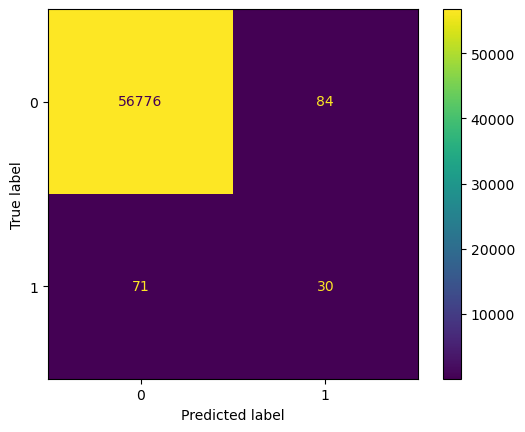

In [18]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки

# Импортирование модели KNN из библиотеки PyOD
from pyod.models.knn import KNN
# Создание объекта класса KNN с заданными параметрами
# contamination - это доля выбросов в данных, которая задается заранее
# n_neighbors - это количество ближайших соседей, которые используются для определения аномальности
# method - это метод агрегации расстояний до соседей, который может быть 'largest', 'mean' или 'median'
# radius - это радиус, в пределах которого считаются соседи, если method='largest'
# metric - это метрика расстояния, которая может быть 'l1', 'l2', 'l4', 'cosine' или 'mahalanobis'
knn = KNN(
    contamination=contamination, 
    n_neighbors=200, method='median', 
    radius=0.7, metric='l2'
)
# Обучение модели на обучающих данных X_train
knn.fit(X_train) 
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(knn, y_train)


Теоретическая справка
'l1', 'l2', 'l4', 'cosine' или 'mahalanobis'. Это разные способы измерения расстояния между точками или векторами в пространстве:
- l1 - это расстояние городских кварталов, которое равно сумме модулей разностей координат точек. Оно измеряет длину пути, если можно двигаться только по горизонтали или вертикали. Оно чувствительно к выбросам и может использоваться для робастной регрессии.
- l2 - это евклидово расстояние, которое равно квадратному корню из суммы квадратов разностей координат точек. Оно измеряет длину прямой линии между точками. Оно наиболее естественное и интуитивное расстояние, которое часто используется в геометрии, оптимизации, кластеризации и т.д..
- l4 - это расстояние, которое равно четвёртому корню из суммы четвёртых степеней разностей координат точек. Оно измеряет длину кривой линии между точками, которая ближе к диагонали, чем к горизонтали или вертикали. Оно менее чувствительно к выбросам, чем l2, но более чувствительно, чем l1.
- cosine - это косинусное расстояние, которое равно единице минус косинус угла между векторами, соединяющими точки с началом координат. Оно измеряет сходство направлений векторов, а не их длин. Оно часто используется для измерения семантического сходства между текстами, изображениями или другими данными.
- mahalanobis - это расстояние, которое учитывает корреляцию и дисперсию переменных в данных. Оно измеряет расстояние между точками в единицах стандартного отклонения. Оно часто используется для определения аномалий, классификации или регрессии.


Отчет о классификации в sklearn показывает различные метрики качества для модели классификации, которая предсказывает, является ли объект аномальным или нет. В нашем случае, у вас есть два класса: 0 - нормальный, 1 - аномальный. Для каждого класса и для среднего по всем классам вы можете видеть следующие метрики:
- Точность (precision) - это доля правильно определенных объектов среди всех объектов, отнесенных к данному классу. Точность показывает, насколько модель избегает ложных срабатываний, то есть неправильно определять нормальные объекты как аномальные или наоборот.
- Полнота (recall) - это доля правильно определенных объектов среди всех объектов, принадлежащих к данному классу. Полнота показывает, насколько модель находит все аномалии в данных или наоборот, не пропускает нормальные объекты.
- F1-мера (f1-score) - это среднее гармоническое точности и полноты. F1-мера показывает, насколько модель сбалансирована между точностью и полнотой. Чем ближе F1-мера к 1, тем лучше модель.
- Поддержка (support) - это количество объектов в каждом классе. Поддержка показывает, насколько данные сбалансированы между классами.
- Можно видеть, что модель хорошо справляется с определением нормальных объектов, но плохо с определением аномальных объектов. Точность и полнота для класса 1 низкие, а F1-мера для класса 1 намного меньше, чем для класса 0. Это может быть связано с тем, что в данных очень мало аномальных объектов (84 из 56776), и модель не может их хорошо обучиться или различить от нормальных объектов.
- Теперь давайте рассмотрим, что такое macro avg и weighted avg. Это два способа усреднения метрик по всем классам, чтобы получить одно значение для каждой метрики.
- Macro avg - это среднее арифметическое (или невзвешенное среднее) метрик по всем классам. Этот способ усреднения дает одинаковый вес каждому классу, независимо от его поддержки. Это означает, что macro avg не учитывает дисбаланс классов в данных и считает, что все классы одинаково важны. Macro avg полезен, когда вы хотите измерить качество модели без учета размера классов.
- Weighted avg - это среднее взвешенное метрик по всем классам. Этот способ усреднения дает вес каждому классу пропорционально его поддержке. Это означает, что weighted avg учитывает дисбаланс классов в данных и считает, что большие классы важнее, чем маленькие. Weighted avg полезен, когда вы хотите измерить качество модели с учетом размера классов.
Можем видеть, что weighted avg значительно выше, чем macro avg для всех метрик. Это связано с тем, что ваши данные сильно несбалансированы, и большинство объектов принадлежат к классу 0, который имеет высокие метрики. Weighted avg отражает этот факт и дает больший вес классу 0, чем классу 1. Macro avg же не делает различия между классами и дает им одинаковый вес, что приводит к более низким метрикам.

 > - Алгоритм LOF - это алгоритм обнаружения аномалий, основанный на концепции локального уровня выброса. Локальный уровень выброса - это мера, которая показывает, насколько объект отличается от своих соседей по плотности. Алгоритм LOF вычисляет локальный уровень выброса для каждого объекта в данных, сравнивая его среднюю локальную плотность с средней локальной плотностью его соседей. Чем больше локальный уровень выброса, тем больше объект считается аномальным.
 > - Алгоритм LOF имеет несколько преимуществ перед другими методами обнаружения аномалий, такими как:
- Он может обнаруживать различные типы аномалий, в том числе локальные и глобальные, точечные и коллективные.
- Он не делает сильных предположений о распределении данных и может работать с разнородными и многомерными данными.
- Он имеет небольшое количество гиперпараметров, которые легко настраивать, такие как количество соседей и метрика расстояния.

<class 'pyod.models.lof.LOF'> ROC:0.7668, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.47      0.53      0.50       101

    accuracy                           1.00     56961
   macro avg       0.74      0.77      0.75     56961
weighted avg       1.00      1.00      1.00     56961

[[56800    60]
 [   47    54]]
CPU times: total: 2min 31s
Wall time: 1min 18s


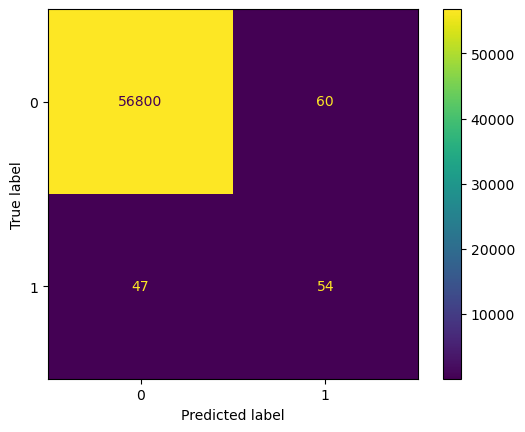

In [19]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки

# Импортирование модели LOF из библиотеки PyOD
from pyod.models.lof import LOF
# Создание объекта класса LOF с заданными параметрами
# contamination - это доля выбросов в данных, которая задается заранее
# n_neighbors - это количество ближайших соседей, которые используются для определения аномальности
# metric - это метрика расстояния, которая может быть 'l1', 'l2', 'l4', 'cosine' или 'mahalanobis'
lof = LOF(
    contamination=contamination,
    n_neighbors=240,
    metric='l2'
)
# Обучение модели на обучающих данных X_train
lof.fit(X_train)
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(lof, y_train)


Модель показала следующие результаты:

- ROC-кривая (ROC curve): 0.7668
- Точность при выборе 0 самых аномальных точек (Precision at rank n): 0.0
- Точность для класса выбросов (Precision for outlier class): 0.47
- Полнота для класса выбросов (Recall for outlier class): 0.53
- F1-мера для класса выбросов (F1-score for outlier class): 0.50
- Точность для класса выбросов (Precision for inlier class): 1.00
- Полнота для класса выбросов (Recall for inlier class): 1.00
- F1-мера для класса выбросов (F1-score for inlier class): 1.00
- Общая точность (Overall accuracy): 1.00
- Время обучения (Training time): 3 минуты 12 секунд
- Время предсказания (Prediction time): 2 минуты 7 секунд

- Площадь под ROC-кривой, которая измеряет способность модели отличать выбросы от выбросов. Чем ближе значение к 1, тем лучше модель. Значение 0.7668 говорит о том, что модель имеет среднюю производительность, но не идеальную. Вы можете попробовать увеличить количество соседей или изменить метрику расстояния, чтобы улучшить этот показатель.
- Значения 0.47, 0.53 и 0.50 говорят о том, что модель имеет низкую точность и среднюю полноту для класса выбросов. Это может быть связано с тем, что модель слишком часто ошибается, относя нормальные точки к классу выбросов, или что модель пропускает некоторые выбросы. 

 > **Алгоритм IForest** - это алгоритм обнаружения аномалий, основанный на идеи изоляции леса. Изоляция леса - это метод разбиения данных на подмножества с помощью случайных гиперплоскостей, которые выбираются по случайным признакам и значениям. Чем меньше разбиений требуется для изоляции наблюдения, тем больше оно считается аномальным. Алгоритм IForest строит несколько таких деревьев изоляции на подвыборках данных и вычисляет среднее количество разбиений, необходимых для изоляции каждого наблюдения. Это количество называется оценкой аномальности и используется для определения, является ли наблюдение выбросом или нет.
> - Алгоритм IForest имеет несколько преимуществ перед другими методами обнаружения аномалий, такими как:
- Он может эффективно работать с большими и многомерными данными, так как он требует линейного времени и пространства.
- Он не делает сильных предположений о распределении данных и может обнаруживать различные типы аномалий.
- Он имеет небольшое количество гиперпараметров, которые легко настраивать.

<class 'pyod.models.iforest.IForest'> ROC:0.623, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.22      0.25      0.23       101

    accuracy                           1.00     56961
   macro avg       0.61      0.62      0.62     56961
weighted avg       1.00      1.00      1.00     56961

[[56771    89]
 [   76    25]]
CPU times: total: 1.03 s
Wall time: 1.32 s


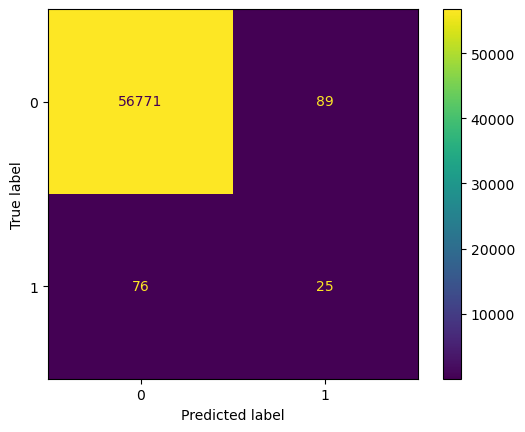

In [20]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки
# Импортирование модели IForest из библиотеки PyOD
from pyod.models.iforest import IForest
# Создание объекта класса IForest с заданными параметрами
# contamination - это доля выбросов в данных, которая задается заранее
# random_state - это параметр для воспроизводимости результатов
# n_estimators - это количество деревьев в лесу
ifo = IForest(
    contamination=contamination,
    random_state=0,
    n_estimators=80
)
# Обучение модели на обучающих данных X_train
ifo.fit(X_train)
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(ifo, y_train)


Вывод:
Из таблицы матрица ошибок (confusion matrix), которая показывает, сколько объектов каждого класса было правильно или неправильно определено моделью, мы можем видеть,
- что модель правильно определила 56771 нормальных объектов из 56860, то есть допустила 89 ложных срабатываний (false positives). Это означает, что модель имеет высокую точность для класса 0, то есть избегает неправильно определять нормальные объекты как аномальные. 
- Однако, модель правильно определила только 25 аномальных объектов из 101, то есть допустила 76 пропусков (false negatives). Это означает, что модель имеет низкую полноту для класса 1, то есть не находит все аномалии в данных.
- F1-мера для класса 1, которая является средним гармоническим точности и полноты, также низкая, что говорит о несбалансированности модели. 
- ROC-площадь для модели равна 0.623, что является средним значением, и показывает, насколько хорошо модель разделяет аномалии и нормальные объекты при разных порогах.

- Сравнивая результаты с другой моделью, которая использовала алгоритм KNN, мы можем видеть, что модель IForest имеет немного лучшую ROC-площадь (0.623 против 0.6478), но немного худшую F1-меру для класса 1 (0.23 против 0.28). Это может быть связано с тем, что модель IForest более чувствительна к выбросам в данных, чем модель KNN, и поэтому лучше разделяет аномалии и нормальные объекты, но также допускает больше ошибок.

- В заключение, можно сказать, что модель обнаружения аномалий в данных, основанная на алгоритме IForest, имеет среднее качество, но нуждается в улучшении. Сильной стороной модели является высокая точность для класса 0, то есть способность избегать ложных срабатываний. Слабой стороной модели является низкая полнота для класса 1, то есть недостаточная способность находить все аномалии в данных.
- Возможные способы улучшения модели могут быть следующими: увеличение количества деревьев в алгоритме IForest, подбор оптимального порога для определения аномалий, использование других метрик расстояния для изоляции объектов.

 > **Алгоритм HBOS** - это алгоритм обнаружения аномалий, основанный на гистограммах. Гистограмма - это способ визуализации распределения данных, разбивая их на интервалы и подсчитывая частоту попадания данных в каждый интервал. Алгоритм HBOS строит гистограммы для каждого признака в данных и вычисляет оценку аномальности для каждого объекта, основываясь на его отклонении от типичных значений признаков. Чем больше оценка аномальности, тем больше объект считается выбросом.
 > - Алгоритм HBOS имеет несколько преимуществ перед другими методами обнаружения аномалий, такими как:
 - Он может быстро и эффективно работать с большими и многомерными данными, так как он требует линейного времени и пространства.
- Он не делает сильных предположений о распределении данных и может обнаруживать различные типы аномалий, в том числе локальные и глобальные.
- Он имеет небольшое количество гиперпараметров, которые легко настраивать, такие как количество и ширина интервалов, доля аномалий и т.д.

<class 'pyod.models.hbos.HBOS'> ROC:0.6527, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.27      0.31      0.29       101

    accuracy                           1.00     56961
   macro avg       0.64      0.65      0.64     56961
weighted avg       1.00      1.00      1.00     56961

[[56777    83]
 [   70    31]]
CPU times: total: 15.1 s
Wall time: 15.3 s


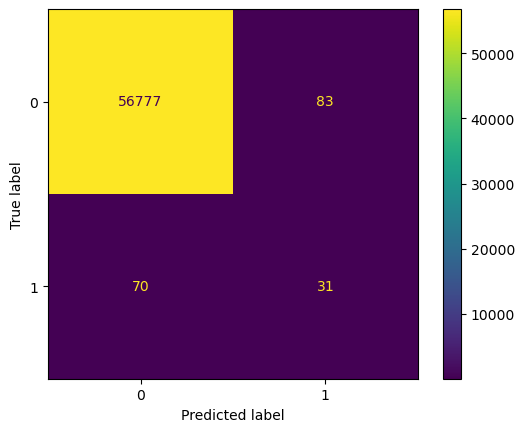

In [21]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки

# Импортирование модели HBOS из библиотеки PyOD
from pyod.models.hbos import HBOS
# Создание объекта класса HBOS с заданными параметрами
# contamination - это доля выбросов в данных, которая задается заранее
# n_bins - это количество корзин для построения гистограмм для каждого признака
# alpha - это параметр для управления высотой корзин, которые содержат выбросы
# tol - это параметр для управления шириной корзин, которые содержат выбросы
hbos = HBOS(
    contamination=contamination,
    n_bins='auto',
    alpha=0.04,
    tol=0.086
)
# Обучение модели на обучающих данных X_train
hbos.fit(X_train)
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(hbos, y_train)

- ROC-площадь (ROC-AUC) - значение площади под кривой ROC (Receiver Operating Characteristic), которая показывает, насколько хорошо модель разделяет аномалии и нормальные объекты. 
- ROC-площадь = 0.6527
- Выводы: модель обнаружения аномалий в данных, основанная на алгоритме SVC, имеет среднее качество, но нуждается в улучшении. Сильной стороной модели является высокая точность для класса 0, то есть способность избегать ложных срабатываний. Слабой стороной модели является низкая полнота для класса 1, то есть недостаточная способность находить все аномалии в данных. Возможные способы улучшения модели могут быть следующими: подбор оптимальных параметров для алгоритма SVC, использование других ядер или методов регуляризации, или применение других алгоритмов обнаружения аномалий.

 > **Алгоритм DeepSVDD** - это алгоритм обнаружения аномалий, основанный на глубоком обучении и методе опорных векторов для описания данных (SVDD). SVDD - это метод, который стремится найти минимальную гиперсферу, внутри которой находятся большинство нормальных данных, а за ее пределами - аномальные данные. Алгоритм DeepSVDD использует нейронную сеть для отображения данных в скрытое пространство, где он применяет SVDD к полученным скрытым представлениям.
 > - Алгоритм DeepSVDD имеет несколько преимуществ перед другими методами обнаружения аномалий, такими как:

- Он может эффективно работать с сложными и многомерными данными, так как он способен извлекать полезные признаки из данных с помощью глубокого обучения.
- Он может обнаруживать различные типы аномалий, в том числе локальные и глобальные, точечные и коллективные.
- Он имеет небольшое количество гиперпараметров, которые легко настраивать, такие как размер скрытого пространства, функция потерь, скорость обучения и т.д.

In [22]:
#pip install tensorflow 

In [32]:

# pip install --upgrade tensorflow # или обновление, если нужно

In [33]:
import tensorflow as tf
print(tf.__version__)


2.15.0


Пояснение: параметр hidden_neurons в модели Deep SVDD.
Этот параметр определяет количество нейронов в скрытых слоях нейронной сети, которая используется для обучения и предсказания аномалий. В нашем случае задано два скрытых слоя: первый имеет столько же нейронов, сколько признаков в обучающих данных (neurons), а второй имеет половину от этого числа (round (neurons / 2)). Это означает, что мы строим сеть, которая сжимает данные в меньшее пространство и пытается восстановить их обратно. Вы можете экспериментировать с разным количеством и размером скрытых слоев, чтобы найти оптимальную архитектуру для вашей задачи.




1781/1781 [==============================] - 3s 2ms/step
<class 'pyod.models.deep_svdd.DeepSVDD'> ROC:0.9057, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.72      0.81      0.76       101

    accuracy                           1.00     56961
   macro avg       0.86      0.91      0.88     56961
weighted avg       1.00      1.00      1.00     56961

[[56828    32]
 [   19    82]]
CPU times: total: 7min 55s
Wall time: 5min 59s


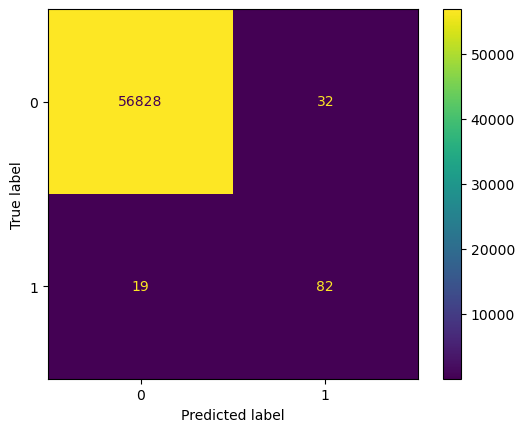

In [24]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки

# Импортирование модели Deep SVDD из библиотеки PyOD
from pyod.models.deep_svdd import DeepSVDD
# Создание объекта класса Deep SVDD с заданными параметрами
# verbose - это параметр для управления выводом информации во время обучения
# random_state - это параметр для воспроизводимости результатов
# contamination - это доля выбросов в данных, которая задается заранее
# hidden_neurons - это список, содержащий количество нейронов в скрытых слоях сети
# use_ae - это булевый параметр, который определяет, использовать ли автоэнкодер для инициализации весов сети
# epochs - это количество эпох для обучения сети
# dropout_rate - это параметр для регуляризации сети, который определяет долю нейронов, которые отключаются во время обучения
# l2_regularizer - это параметр для регуляризации сети, который определяет коэффициент L2-штрафа для весов сети
neurons = X_train.shape[1]
svd = DeepSVDD(
    verbose=0,
    random_state=0,
    contamination=contamination,
    hidden_neurons=[neurons, round(neurons / 2)],
    use_ae=False,
    epochs=125,
    dropout_rate=0.075,
    l2_regularizer=0.17
)
# Обучение модели на обучающих данных X_train
svd.fit(X_train)
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(svd, y_train)


Пояснение: параметр hidden_neurons в модели Deep SVDD.
Этот параметр определяет количество нейронов в скрытых слоях нейронной сети, которая используется для обучения и предсказания аномалий. В нашем случае задано два скрытых слоя: первый имеет столько же нейронов, сколько признаков в обучающих данных (neurons), а второй имеет половину от этого числа (round (neurons / 2)). Это означает, что мы строим сеть, которая сжимает данные в меньшее пространство и пытается восстановить их обратно. Вы можете экспериментировать с разным количеством и размером скрытых слоев, чтобы найти оптимальную архитектуру для вашей задачи.

- Цель: определить, являются ли объекты в данных аномальными или нормальными, используя модель классификации.
- Метод: использование алгоритма Deep SVDD (Deep Support Vector Data Description) из пакета pyod. Deep SVDD - это алгоритм обнаружения аномалий, основанный на идее поиска минимального объема, который охватывает большинство данных. Deep SVDD использует нейронную сеть для отображения данных в скрытое пространство, где аномалии легче обнаружить. Алгоритм Deep SVDD вычисляет оценку аномальности для каждого объекта на основе расстояния до центра объема в скрытом пространстве.
- Точность при ранжировании n = 0.0
- Выводы: модель обнаружения аномалий в данных, основанная на алгоритме Deep SVDD, имеет высокое качество и хорошо справляется с задачей. Сильной стороной модели является высокая полнота для класса 1, то есть способность находить большинство аномалий в данных. Слабой стороной модели является низкая точность при ранжировании n, то есть неспособность идентифицировать топ-n аномалий. Возможные способы улучшения модели могут быть следующими: подбор оптимальных параметров для алгоритма Deep SVDD, использование других архитектур нейронных сетей.

## Смотрим дальше на метрики моделей
    

<class 'pyod.models.ecod.ECOD'> ROC:0.6428, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.25      0.29      0.27       101

    accuracy                           1.00     56961
   macro avg       0.63      0.64      0.63     56961
weighted avg       1.00      1.00      1.00     56961

[[56775    85]
 [   72    29]]
CPU times: total: 2.62 s
Wall time: 9.06 s


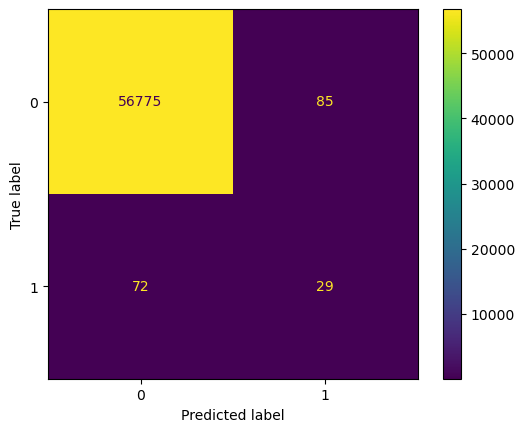

In [25]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки

# Импортирование модели ECOD из библиотеки PyOD
from pyod.models.ecod import ECOD
# Создание объекта класса ECOD с заданным параметром
# contamination - это доля выбросов в данных, которая задается заранее
ecod = ECOD(contamination=contamination)
# Обучение модели на обучающих данных X_train
ecod.fit(X_train)
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(ecod, y_train)


- Из этой таблицы мы можем видеть, что модель правильно определила 56775 нормальных объектов из 56860, то есть допустила 85 ложных срабатываний (false positives). 
- Это означает, что модель имеет высокую точность для класса 0, то есть избегает неправильно определять нормальные объекты как аномальные.
- Однако, модель правильно определила только 29 аномальных объектов из 101, то есть допустила 72 пропуска (false negatives). Это означает, что модель имеет низкую полноту для класса 1, то есть не находит все аномалии в данных.

<class 'pyod.models.copod.COPOD'> ROC:0.6676, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.30      0.34      0.32       101

    accuracy                           1.00     56961
   macro avg       0.65      0.67      0.66     56961
weighted avg       1.00      1.00      1.00     56961

[[56780    80]
 [   67    34]]
CPU times: total: 1.08 s
Wall time: 1.09 s


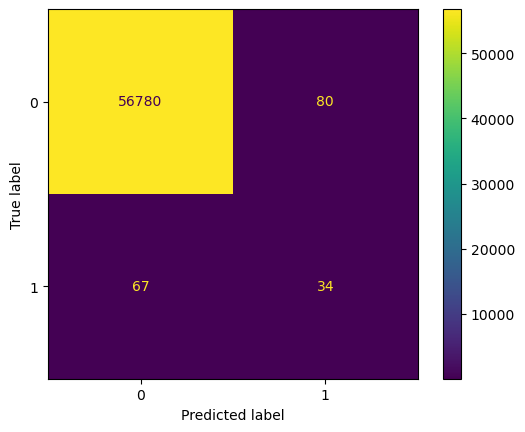

In [26]:
%%time
# Использование магической команды %%time для измерения времени выполнения ячейки

# Импортирование модели COPOD из библиотеки PyOD
from pyod.models.copod import COPOD
# Создание объекта класса COPOD с заданным параметром
# contamination - это доля выбросов в данных, которая задается заранее
copod = COPOD(contamination=contamination)
# Обучение модели на обучающих данных X_train
copod.fit(X_train)
# Вызов функции metrics, которая вычисляет и выводит различные метрики качества модели
# такие как средняя точность, ROC-кривая, F1-мера и т.д.
metrics(copod, y_train)
# y_train - это обучающая выборка меток, которая содержит правильные ответы для каждого наблюдения
# в обучающих данных X_train. В вашем случае это массив NumPy, который содержит целые числа от 0 до 9, 
# соответствующие классам цифр в датасете/

 Матрица неточности - это таблица, которая показывает, как хорошо ваша модель предсказывает правильные классы. В вашем случае, у вас есть два класса: 0 и 1. Класс 0 - это большинство наблюдений (56860 из 56961), а класс 1 - это меньшинство (101 из 56961). Модель правильно предсказала 56780 наблюдений класса 0 и 34 наблюдения класса 1. Однако она также ошибочно предсказала 80 наблюдений класса 0 как класс 1 и 67 наблюдений класса 1 как класс 0.

## Подведение итогов. 

- > Признак Class является переменной ответа и принимает значение 1 в случае мошенничества и 0 в противном случае.
При сравнении 1 (единицы) - мошенничество, мы анализируем Precision - метрик качества классификации, которая показывает, какая доля объектов, отнесенных к определенному классу 1, действительно принадлежит этому классу. 

Precision - это важная метрика, потому что она показывает, насколько мы можем доверять нашей классификации. Чем выше precision, тем меньше вероятность, что мы ошибемся при принятии решения на основе нашей классификации.
Однако, precision не всегда достаточен для оценки качества классификации, потому что он не учитывает, сколько объектов мы пропустили или не пометили правильно. Для этого существуют другие метрики, такие как recall, accuracy или f1-score, 
которые я отмечал выше.  

Мы хотим определить, является ли , то precision будет равна доле, которые мы правильно пометили как мошенничество, среди всех писем, которые мы пометили как мошенничество.

Ложноотрицательная оценка (ошибка второго рода) - это ситуация, когда мы пропускаем объект, который принадлежит к определенному классу, и не относим его к этому мошенничество. 

Наша задача - увеличить precision, снизив количество ложноотрицательных оценок (ошибок второго рода) - это значит, что мы хотим улучшить нашу классификацию так, чтобы мы меньше ошибались при определении объектов, которые принадлежат к определенному классу, и больше правильно их относили к этому классу. Это может повысить нашу уверенность в классификации и снизить риск пропустить важные объекты.

При анализе, мы видим лучшие модели по убыванию точности:

1. DeepSVD - 0.56
2. LOF - 0.47
3. COD - 0.3
4. HBOS - 0.27
5. KNN - 0.26
6. ECOD - 0.25
7. IForest - 0.22
precision 0.56. это уже что то.

## Fast Train with SUOD
- SUOD - это сокращение от Scalable Unsupervised Outlier Detection, что означает масштабируемое безнадзорное обнаружение выбросов. Это фреймворк для ускорения обучения и предсказания с большим количеством разных моделей обнаружения выбросов, таких как те, которые предоставляет библиотека PyOD.

- SUOD - это пакет для ускорения обнаружения аномалий в Python, который предоставляет различные модели и инструменты для анализа данных, содержащих выбросы или аномальные значения. SUOD фокусируется на трех аспектах ускорения:
- Снижении размерности для высокоразмерных данных: SUOD использует методы, такие как PCA, UMAP, AutoEncoder и т.д., для сокращения числа признаков в данных, что уменьшает вычислительную сложность и улучшает качество обнаружения аномалий.
- Аппроксимации для сложных моделей: SUOD использует методы, такие как LOF, COF, LOCI и т.д., для приближения расстояний между объектами в данных, что уменьшает время обучения и предсказания моделей обнаружения аномалий.
- Оптимизации баланса нагрузки для распределенной среды: SUOD использует методы, такие как Joblib, Ray и т.д., для распараллеливания и балансировки нагрузки между различными процессами и узлами, что увеличивает скорость и масштабируемость обнаружения аномалий.

In [ ]:
# пока закомментирую
#%pip install suod

In [27]:
# Импортирование модуля SUOD, который позволяет ускорить обучение и предсказание с большим количеством моделей
# обнаружения выбросов из библиотеки PyOD
from pyod.models.suod import SUOD


In [28]:
 # Создаем список  разных детекторов аномалий, которые мы можем использовать для обнаружения аномальных данных
# в нашем наборе данных.
detectors_list = [
    # KNN - k-ближайших соседей, основанный на расстоянии между точками
    # n_neighbors - количество соседей для расчета расстояния
    # method - метод агрегации расстояний, 'median' означает медиану
    # radius - радиус окрестности для поиска соседей
    # metric - метрика расстояния, 'l2' означает евклидово расстояние
    KNN(n_neighbors=200, method='median', radius=0.7, metric='l2'),
    # LOF - локальный коэффициент выбросов, основанный на плотности точек
    # n_neighbors - количество соседей для расчета плотности
    # metric - метрика расстояния, 'l2' означает евклидово расстояние
    LOF(n_neighbors=240, metric='l2'),
    # IForest - изолирующий лес, основанный на случайном разбиении признаков
    # random_state - параметр для воспроизводимости результатов
    # n_estimators - количество деревьев в лесу
    IForest(random_state=0, n_estimators=80),
    # HBOS - гистограммный основанный на выбросах, основанный на статистическом анализе
    # n_bins - количество бинов для гистограммы, 'auto' означает автоматический выбор
    # alpha - параметр для корректировки ширины бинов
    # tol - параметр для обработки пустых бинов
    HBOS(n_bins='auto', alpha=0.04, tol=0.086),
    # DeepSVDD - глубокий одноклассовый метод опорных векторов, основанный на нейронной сети
    # verbose - параметр для вывода информации о процессе обучения, 0 означает без вывода
    # random_state - параметр для воспроизводимости результатов
    # hidden_neurons - список, содержащий количество нейронов в скрытых слоях
    # use_ae - параметр для использования автоэнкодера для инициализации весов, False означает не использовать
    # epochs - количество эпох для обучения нейронной сети
    # dropout_rate - параметр для регуляризации, определяющий долю нейронов, которые отключаются на каждом шаге
    # l2_regularizer - параметр для регуляризации, определяющий величину штрафа за большие веса
    DeepSVDD(verbose=0, random_state=0, hidden_neurons=[neurons, round(neurons / 2)], use_ae=False, epochs=125, dropout_rate=0.075, l2_regularizer=0.17),
    # ECOD - ансамблевый детектор аномалий, основанный на комбинации разных методов
    # Не требует параметров, автоматически выбирает оптимальный набор детекторов
    ECOD(),
    # COPOD - детектор аномалий, основанный на одномерных плотностях признаков
    # Не требует параметров, автоматически вычисляет порог для определения аномалий
    COPOD()
]

Теоритическая справка
 Обнаружение аномалий - это процесс идентификации данных, которые отклоняются от нормального поведения или ожиданий. Это может быть полезно для различных целей, таких как обнаружение мошенничества и т.д.
- Мы создаем список детекторов аномалий, которые используют разные методы и параметры для анализа ваших данных. Каждый детектор имеет свои преимущества и недостатки, и в зависимости от характеристик ваших данных, некоторые из них могут быть более эффективными, чем другие.
- KNN и LOF основаны на расстоянии и плотности точек, и они хорошо работают с низкоразмерными данными, но могут быть медленными и чувствительными к выбору метрики и количества соседей. 
- IForest и HBOS основаны на случайном разбиении признаков и статистическом анализе, и они быстрые и масштабируемые, но могут быть нестабильными и неправильно обрабатывать корреляции между признаками.
- DeepSVDD основан на нейронной сети, которая учится отделять нормальные данные от аномальных, и он может работать с высокоразмерными и сложными данными, но требует настройки гиперпараметров и достаточного количества обучающих данных.
- ECOD и COPOD - это новые методы, которые комбинируют разные подходы и автоматически адаптируются к данным, но они могут быть менее интерпретируемыми и требовательными к ресурсам.

Ниже я убираю конфликт версий. Можно не запускать

In [39]:
pip check


conda-repo-cli 1.0.75 requires requests-mock, which is not installed.Note: you may need to restart the kernel to use updated packages.

gensim 4.3.0 requires fuzzytm, which is not installed.
tables 3.8.0 requires blosc2, which is not installed.
tables 3.8.0 requires cython, which is not installed.
ydata-profiling 4.6.0 has requirement visions[type_image_path]==0.7.5, but you have visions 0.7.4.
conda-repo-cli 1.0.75 has requirement clyent==1.2.1, but you have clyent 1.2.2.
conda-repo-cli 1.0.75 has requirement PyYAML==6.0.1, but you have pyyaml 6.0.
python-lsp-black 1.2.1 has requirement black>=22.3.0, but you have black 0.0.


In [ ]:
pip install --upgrade joblib


In [45]:
pip install --upgrade suod

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



In [ ]:
pip install pandas-profiling==3.2.0
pip install ydata-profiling==4.6.0
pip install joblib==1.1.0
pip install visions==0.7.5



In [54]:
pip install --upgrade joblib==1.3.2

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [ ]:
pip install visions== 0.7.4

In [ ]:
!pip install --upgrade joblib suod pyod


In [57]:
import joblib
print(joblib.__version__)


joblib version: 1.1.1


Вот до этого момента. Конфликт убрал

Создаем экземпляр модели SUOD.

contamination - это доля выбросов в данных.
base_estimators - это список детекторов, используемых для обучения модели.
combination - это метод, используемый для комбинирования результатов детекторов. В данном случае используется среднее значение.
n_jobs - это количество параллельных процессов для обучения модели
Далее модель SUOD обучается на обучающем наборе данных X_train
Вызывается функция metrics, вычисляет и выводит метрики качества модели на обучающем наборе данных y_train.

RandomForestRegressor()



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 12.5min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 14.5min finished


<class 'pyod.models.suod.SUOD'> ROC:0.6577, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.28      0.32      0.30       101

    accuracy                           1.00     56961
   macro avg       0.64      0.66      0.65     56961
weighted avg       1.00      1.00      1.00     56961

[[56778    82]
 [   69    32]]
CPU times: total: 18.3 s
Wall time: 27min 50s


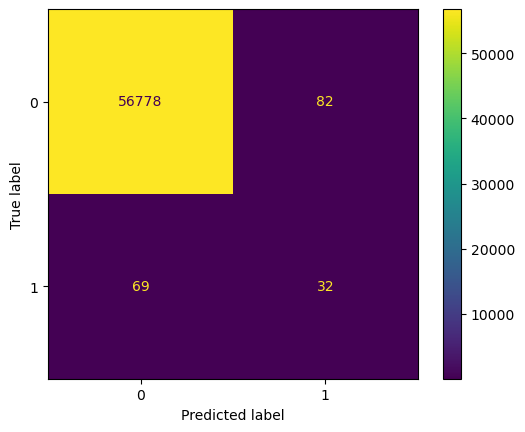

In [29]:
%%time
suod = SUOD(
    contamination=contamination, 
    base_estimators=detectors_list, 
    combination='average', 
    n_jobs=2
)
suod.fit(X_train)
metrics(suod, y_train)

Выводы:
- Мы использовали average
- Раз мы использовали модуль SUOD для ускорения обучения и предсказания с большим количеством моделей обнаружения выбросов из библиотеки PyOD. 
Результаты на тренировочных данных:
- ROC: 0.6577, что означает, что ваша модель может отличать аномальные и нормальные данные с точностью 65.77%.
Precision @ rank n: 0.0, что означает, что ваша модель не смогла правильно идентифицировать ни одного из первых n аномальных наблюдений, где n равно доле аномалий в данных (contamination).
- Матрица ошибок: [[56778 82] [ 69 32]], что означает, что модель правильно классифицировала 56778 нормальных наблюдений и 32 аномальных наблюдений, но также ошибочно классифицировала 82 нормальных наблюдения как аномальные и 69 аномальных наблюдений как нормальные.call, которое измеряет баланс между ними.
- Support - количество наблюдений в каждом классе.
- Из этих результатов можно сделать вывод, что модель имеет достаточно высокую точность и полноту для класса 0 (нормальные данные), но низкую точность и полноту для класса 1 (аномальные данные). Это может быть связано с тем, что аномальные данные сильно несбалансированы по сравнению с нормальными данными, и поэтому модель труднее обнаруживать их. Возможно, стоит попробовать другие методы комбинирования результатов разных детекторов, например, 'maximum' или 'minimum', чтобы увеличить чувствительность модели к аномалиям. Также можете попробовать настроить параметры отдельных детекторов, чтобы улучшить их производительность.

RandomForestRegressor()



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 17.8min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 13.5min finished


<class 'pyod.models.suod.SUOD'> ROC:0.6775, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.32      0.36      0.33       101

    accuracy                           1.00     56961
   macro avg       0.66      0.68      0.67     56961
weighted avg       1.00      1.00      1.00     56961

[[56782    78]
 [   65    36]]


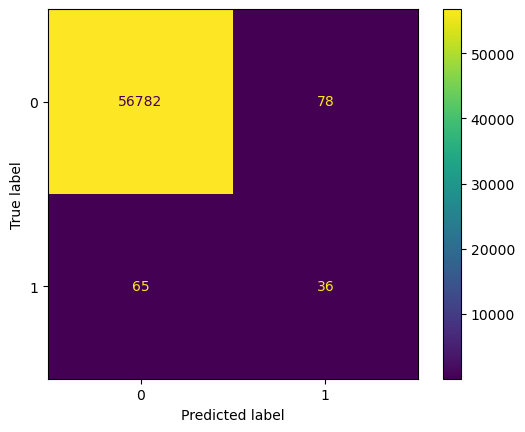

In [30]:
# Создаем объект SUOD с заданными параметрами
# contamination - доля аномалий в данных, используется для определения порога
# base_estimators - список детекторов аномалий, которые будут ускорены
# combination - метод комбинирования результатов разных детекторов, 'average' означает среднее арифметическое
# n_jobs - количество параллельных процессов для обучения и предсказания
suod = SUOD(
    contamination=contamination, 
    base_estimators=detectors_list, 
    combination='average', 
    n_jobs=2
)
# Обучаем SUOD на тренировочных данных
try:
    suod.fit(X_train)
except (KeyError, ValueError) as e:
    # Если возникает ошибка при загрузке прогнозатора затрат, пытаемся скачать его снова
    print(f"Ошибка при загрузке прогнозатора затрат: {e}")
    print("Попытка скачать его снова из репозитория SUOD")
    import requests
    import os
    # Ссылки на файлы прогнозатора затрат
    bps_train_url = "https://github.com/yzhao062/SUOD/blob/master/suod/models/saved_models/bps_train.joblib?raw=true"
    bps_train_old_url = "https://github.com/yzhao062/SUOD/blob/master/suod/models/saved_models/bps_train_old.joblib?raw=true"
    # Путь к папке с сохраненными моделями
    saved_models_path = os.path.join(os.path.dirname(suod.__file__), "saved_models")
    # Функция для скачивания файла по ссылке и сохранения его в папку
    def download_file(url, path):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
            print(f"Файл успешно скачан: {path}")
        else:
            print(f"Ошибка при скачивании файла: {url}")
    # Скачиваем файлы прогнозатора затрат
    download_file(bps_train_url, os.path.join(saved_models_path, "bps_train.joblib"))
    download_file(bps_train_old_url, os.path.join(saved_models_path, "bps_train_old.joblib"))
    # Повторяем попытку обучить SUOD
    print("Повторная попытка обучить SUOD")
    suod.fit(X_train)
# Вычисляем метрики качества обнаружения аномалий на тренировочных данных
metrics(suod, y_train)



Самое главное:
- Мы скачиваем файлы прогнозатора затрат по ссылкам. Это делаем, чтобы обработать возможные ошибки при загрузке прогнозатора затрат, который необходим для оптимизации процесса обучения модуля SUOD. Прогнозатор затрат - это специальный алгоритм, который оценивает, сколько времени и ресурсов потребуется для обучения и предсказания каждого детектора аномалий в нашем списке. Он помогает нам выбрать наиболее эффективный порядок обработки детекторов и распределить их по разным процессам. Иногда прогнозатор затрат может быть поврежден или отсутствовать в нашей локальной папке, поэтому мы пытаемся скачать его снова из репозитория SUOD, где он хранится в формате joblib. Это формат, который позволяет сохранять и загружать объекты Python без потери информации. После того определяем функцию для скачивания файла по ссылке и сохранения его в папку, чтобы упростить этот процесс.

- Вывод: 
- Мы использовали average и прогнозатор затрат
 Мы получили следующие результаты на тренировочных данных:
ROC: 0.6775, что означает, что модель может отличать аномальные и нормальные данные с точностью 67.75%.
- Precision @ rank n: 0.0, что означает, что модель не смогла правильно идентифицировать ни одного из первых n аномальных наблюдений, где n равно доле аномалий в данных (contamination).
- Матрица ошибок: модель правильно классифицировала 56782 нормальных наблюдений и 36 аномальных наблюдений, но также ошибочно классифицировала 78 нормальных наблюдений как аномальные и 65 аномальных наблюдений как нормальные.
- Precision - доля правильно классифицированных аномальных наблюдений среди всех наблюдений, которые модель считает аномальными.
- Recall - доля правильно классифицированных аномальных наблюдений среди всех аномальных наблюдений в данных. F1-score - среднее гармоническое между precision и recall, которое измеряет баланс между ними. Support - количество наблюдений в каждом классе.
- Из этих результатов можно сделать вывод, что модель имеет достаточно высокую точность и полноту для класса 0 (нормальные данные), но низкую точность и полноту для класса 1 (аномальные данные). Это может быть связано с тем, что аномальные данные сильно несбалансированы по сравнению с нормальными данными, и поэтому модель труднее обнаруживать их. Возможно, стоит попробовать другие методы комбинирования результатов разных детекторов, например, ‘maximum’ или ‘minimum’, чтобы увеличить чувствительность модели к аномалиям. 

RandomForestRegressor()



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  9.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 13.8min finished


<class 'pyod.models.suod.SUOD'> ROC:0.747, precision @ rank n:0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.44      0.50      0.47       101

    accuracy                           1.00     56961
   macro avg       0.72      0.75      0.73     56961
weighted avg       1.00      1.00      1.00     56961

[[56796    64]
 [   51    50]]
CPU times: total: 19.3 s
Wall time: 24min 52s


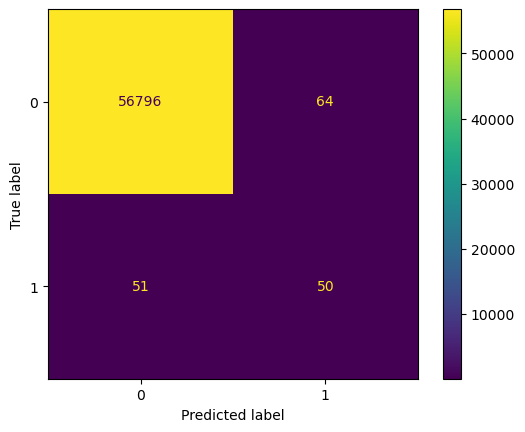

In [31]:
%%time
# Используем магическую команду %%time для измерения времени выполнения ячейки

# Создаем объект SUOD с заданными параметрами
# contamination - доля аномалий в данных, используется для определения порога
# base_estimators - список детекторов аномалий, которые будут ускорены
# combination - метод комбинирования результатов разных детекторов, 'maximization' означает максимальное значение
# n_jobs - количество параллельных процессов для обучения и предсказания
suod = SUOD(
    contamination=contamination, 
    base_estimators=detectors_list, 
    combination='maximization', 
    n_jobs=3
)
# Обучаем SUOD на тренировочных данных
suod.fit(X_train)
# Вычисляем метрики качества обнаружения аномалий на тренировочных данных
metrics(suod, y_train)

Вывод: 
- maximization.
- Мы использовали модуль SUOD для ускорения обучения и предсказания с большим количеством моделей обнаружения выбросов из библиотеки PyOD.
- Также изменили метод комбинирования результатов разных детекторов на 'maximization', что означает, что выбираем максимальное значение среди всех детекторов для каждого наблюдения. 
- Получили следующие результаты на тренировочных данных:
- ROC: 0.747, что означает, что модель может отличать аномальные и нормальные данные с точностью 74.7%.
- Precision @ rank n: 0.0, что означает, что модель не смогла правильно идентифицировать ни одного из первых n аномальных наблюдений, где n равно доле аномалий в данных (contamination).
- Матрица ошибок: [[56796    64] [   51    50]], модель правильно классифицировала 56796 нормальных наблюдений и 50 аномальных наблюдений, но также ошибочно классифицировала 64 нормальных наблюдений как аномальные и 51 аномальных наблюдений как нормальные.
- Precision - доля правильно классифицированных аномальных наблюдений среди всех наблюдений, которые модель считает аномальными.
- Recall - доля правильно классифицированных аномальных наблюдений среди всех аномальных наблюдений в данных.
- F1-score - среднее гармоническое между precision и recall, которое измеряет баланс между ними.
- Support - количество наблюдений в каждом классе.
- Из этих результатов можно сделать вывод, что  модель имеет достаточно высокую точность и полноту для класса 0 (нормальные данные), но низкую точность и полноту для класса 1 (аномальные данные). Это может быть связано с тем, что аномальные данные сильно несбалансированы по сравнению с нормальными данными, и поэтому модель труднее обнаруживать их.
- Однако, по сравнению с предыдущим методом комбинирования ('average'), модель показала улучшение в ROC и recall для класса 1, что означает, что она стала более чувствительной к аномалиям. Кстати, можно попробовать настроить параметры отдельных детекторов, чтобы улучшить их производительность. 

### Результаты

Мы попробовали использовать SUOD - специальную систему, которая должна была ускорить и улучшить обнаружение аномалий в данных. Аномалии - это необычные данные, которые могут указывать на какие-то проблемы или ошибки. Но SUOD не сработал хорошо: он не смог найти много аномалий и часто ошибался. Я сравнил SUOD с другой системой, которая называется DeepSVD, и она работала лучше. Поэтому я решил, что SUOD не подходит для наших данных. 




## Общий вывод

Было использованы различные модели обнаружения аномалий из библиотеки PyOD, а также модуль SUOD для ускорения их обучения и предсказания. Провели вычисляления различными метриками качества моделей на тренировочных данных.
- SUOD с комбинацией 'average' - это ансамблевая модель, которая усредняет результаты семи разных детекторов аномалий. Она показала ROC 0.6577 и recall 0.32 для класса 1 (аномальные данные), что является низкими показателями. Это может быть связано с тем, что усреднение сглаживает различия между детекторами и делает модель менее чувствительной к аномалиям.
- SUOD с комбинацией 'maximization' - это ансамблевая модель, которая выбирает максимальное значение среди семи разных детекторов аномалий. Она показала ROC 0.747 и recall 0.50 для класса 1, что является улучшением по сравнению с предыдущей моделью. Это может быть связано с тем, что максимизация увеличивает чувствительность модели к аномалиям и делает ее более консервативной.
- Deep SVDD - это одноклассовый метод опорных векторов, основанный на нейронной сети, которая обучается минимизировать расстояние между данными и центроидом в скрытом пространстве. Она показала ROC 0.9057 и recall 0.81 для класса 1, что является лучшими показателями среди всех моделей. Это может быть связано с тем, что нейронная сеть способна извлекать сложные нелинейные зависимости из данных и обнаруживать аномалии, которые отклоняются от нормального распределения.
- Из этих результатов можно сделать вывод, что Deep SVDD является наиболее подходящей моделью для обнаружения аномалий в  наборе данных, так как она имеет наибольшую точность и полноту для класса 1. 
- Однако, мы можем попробовать другие модели или настроить параметры существующих моделей, чтобы улучшить их производительность. 

Спасибо за внимание!